In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df_raw = pd.read_csv('hr_employee_churn_data.csv')

In [3]:
df_raw.shape

(14999, 10)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


## Feature Engineering

In [5]:
df = df_raw.drop(['empid'],axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,0.38,0.53,2,157,3,0,0,low,1
1,0.80,0.86,5,262,6,0,0,medium,1
2,0.11,0.88,7,272,4,0,0,medium,1
3,0.72,0.87,5,223,5,0,0,low,1
4,0.37,0.52,2,159,3,0,0,low,1


In [6]:
df.isnull().sum()

satisfaction_level       2
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

In [7]:
df['satisfaction_level'].describe()

count    14997.000000
mean         0.612863
std          0.248634
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [8]:
df['satisfaction_level'] = df['satisfaction_level'].fillna(df['satisfaction_level'].mean())

In [9]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

### Categorical Features

In [10]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [11]:
salary_dummies = pd.get_dummies(df['salary'], drop_first = True)
salary_dummies

,low,medium
0,True,False
1,False,True
2,False,True
3,True,False
4,True,False
...,...,...
14994,True,False
14995,True,False
14996,True,False
14997,True,False


In [12]:
df = pd.concat([df,salary_dummies],axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left,low,medium
0,0.38,0.53,2,157,3,0,0,low,1,True,False
1,0.80,0.86,5,262,6,0,0,medium,1,False,True
2,0.11,0.88,7,272,4,0,0,medium,1,False,True
3,0.72,0.87,5,223,5,0,0,low,1,True,False
4,0.37,0.52,2,159,3,0,0,low,1,True,False


In [13]:
df.drop(['salary'],axis=1,inplace=True)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,low,medium
0,0.38,0.53,2,157,3,0,0,1,True,False
1,0.80,0.86,5,262,6,0,0,1,False,True
2,0.11,0.88,7,272,4,0,0,1,False,True
3,0.72,0.87,5,223,5,0,0,1,True,False
4,0.37,0.52,2,159,3,0,0,1,True,False


## Train and Test Sets

In [14]:
X = df.drop(labels='left',axis=1)
y = df['left']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
X_test.shape

(3000, 9)

## Baseline Model

To do:
- optimal threshold
- evaluation function to compare  models among each others
- add explaination of baseline model

In [17]:
y_pred = (X_test['satisfaction_level'] < 0.5).astype(int)
y_pred

1670     1
13378    0
10233    0
4719     0
7003     0
        ..
14035    0
8469     0
12453    1
9431     0
4202     1
Name: satisfaction_level, Length: 3000, dtype: int64

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2299
           1       0.54      0.71      0.62       701

    accuracy                           0.79      3000
   macro avg       0.72      0.77      0.74      3000
weighted avg       0.82      0.79      0.80      3000



## Model Selection

In [27]:
model_param = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param': {
            'n_estimators': [10, 50, 100, 130],
            'criterion': ['gini','entropy'],
            'max_depth': range(2,4,1),
            'max_features': ['sqrt','log2',None]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(objective='binary:logistic'),
        'param': {
            'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3,5,10,20],
            'n_estimators': [10,50,100,200]
        }
    }
}

In [28]:
scores = []
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'],cv=5,return_train_score=False)
    model_selection.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [29]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': np.float64(0.9231596845908017),
  'best_params': {'criterion': 'entropy',
   'max_depth': 3,
   'max_features': 'sqrt',
   'n_estimators': 10}},
 {'model': 'XGBClassifier',
  'best_score': np.float64(0.988582291232458),
  'best_params': {'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 50}}]

## Model Building

to-do:
- replace hardcode values with results from above
- feature importance graphs

In [31]:
xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.1,max_depth=20,n_estimators=50)
xgb.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [33]:
y_pred = xgb.predict(X_test)

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2299
           1       0.99      0.96      0.98       701

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



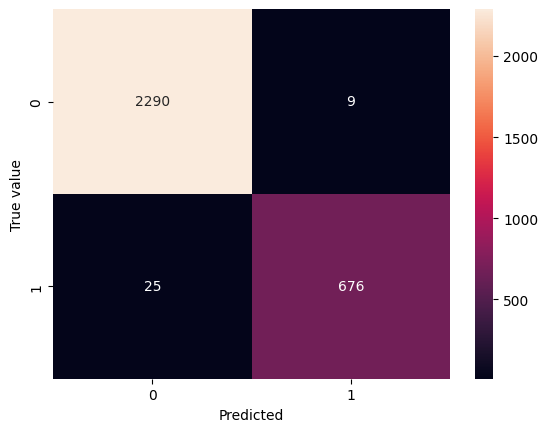

In [37]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True value')
plt.show()